# Лабораторная работа № 1
## Персептроны. Процедура обучения Розенблатта

`Цель работы:` исследование свойств персептрона Розенблатта и его применение для решения задачи распознавания образов

|Студент| Мариничев И.А.|
|-|-|
|**Группа**| **М8О-408Б-19**|
|**Вариант**| **5**|

Импортируем нужные библиотеки

In [1]:
import numpy as np

import torch
import torch.nn as nn

from tqdm import tqdm

import matplotlib.pyplot as plt

Определим первые две группы точек

In [14]:
x1 = [0.3, 4.9, -0.9, 2.6, -4, -1.5]
y1 = [2, -2.2, -0.4, 3.1, -3.3, -4.5]

c1 = [0, 0, 1, 0, 1, 1]

In [15]:
x_train = torch.FloatTensor(np.array(list(zip(x1, y1))))
y_train = torch.FloatTensor(np.array(c1))

Создадим класс персептрона, выполняющий перемножение матрицы весов и матрицы входа с прибавлением вектора смещения

In [16]:
class Perceptron(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

Наш первый персептрон будет принимать на вход два признака, координаты (x, y), и иметь один выходной нейрон. В качестве функции потель берем `nn.L1Loss()`, так как она вычисляет `MAE`

In [17]:
perceptron = Perceptron(2, 1)
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(perceptron.parameters(), lr=0.05)

Определим функцию обучения для бинарной классификации

In [18]:
def fit(model, x_train, y_train, criterion, optimizer, epochs):
    losses = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            optimizer.zero_grad()
            outp = model(x_train)

            probabilities = torch.sigmoid(outp.view(-1))
            # preds = (probabilities > 0.5).type(torch.long)
            loss = criterion(probabilities, y_train)

            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

Обучим модель

In [ ]:
losses = fit(perceptron, x_train, y_train, loss_function, optimizer, 1000)

Посмотрим на график функции потерь, вычисляющий MAE между исходными и полученными данными

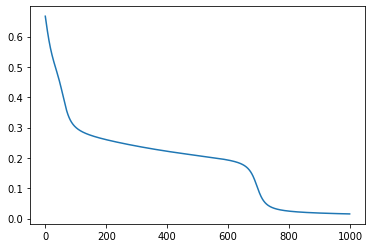

In [20]:
plt.plot(losses)
plt.show()

In [21]:
current_weights = perceptron.weights.detach().clone()
w = current_weights.flatten().numpy()

current_bias = perceptron.bias_term.detach().clone()
b = current_bias.flatten().numpy()

И посмотрим на разделяющую прямую

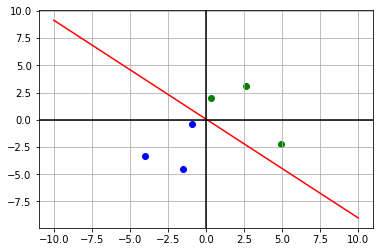

In [22]:
X = np.linspace(-10, 10, 100)

def discriminant(x):
    return (-x * w[0] - b[0])/w[1]

plt.plot(X, discriminant(X), "red")

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

for x, y, c in list(zip(x1, y1, y_train)):
    if (c == 1):
        plt.scatter(x, y, c="blue")
    else:
        plt.scatter(x, y, c="green")

plt.show()

Повторим аналогичный процесс для 4-х классового случая

Определим группы точек

In [2]:
x2 = [-3.5, -0.7, 1.1, 3.6, 4, 0.1, 0.5, 2.6]
y2 = [-4.9, 3.3, 0.2, -4.1, -4, -3.6, -5, 3.4]


c2_1 = [1, 0, 0, 0, 0, 1, 1, 0]
c2_2 = [0, 0, 0, 1, 1, 0, 0, 0]

In [3]:
x_train2 = torch.FloatTensor(np.array(list(zip(x2, y2))))
y_train2 = torch.FloatTensor(np.array(list(zip(c2_1, c2_2))))

Наш второй персептрон будет принимать на вход два признака, координаты (x, y) и иметь два выходных нейрона

In [6]:
perceptron2 = Perceptron(2, 2)
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(perceptron2.parameters(), lr=0.05)

Определим функцию обучения для многоклассовой классификации

In [7]:
def fit2(model, x_train, y_train, criterion, optimizer, epochs):
    losses = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            optimizer.zero_grad()
            outp = model(x_train)

            probaba = torch.sigmoid(outp)

            loss1 = criterion(probaba[:, 0], y_train[:, 0])
            loss2 = criterion(probaba[:, 1], y_train[:, 1])
            loss = loss1 + loss2

            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

Обучим модель

In [ ]:
losses2 = fit2(perceptron2, x_train2, y_train2, loss_function, optimizer, 1000)

Посмотрим на график функции потерь, вычисляющий MAE между исходными и полученными данными

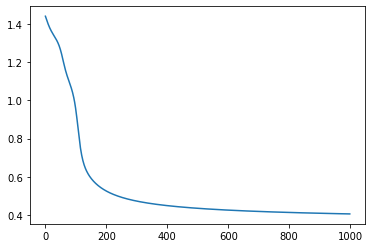

In [9]:
plt.plot(losses2)
plt.show()

In [10]:
current_weights = perceptron2.weights.detach().clone()
w = current_weights.numpy()

current_bias = perceptron2.bias_term.detach().clone()
b = current_bias.numpy()

In [ ]:
def reverse_one_hot(arr):
    arr_new = []

    for i, y in enumerate(arr):
        arr_new.append(int(str(y[0]) + str(y[1]), 2))

    return np.array(arr_new)

И посмотрим на разделяющие прямые

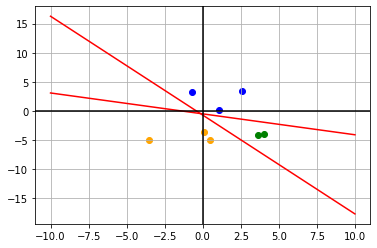

In [13]:
X = np.linspace(-10, 10, 100)

def discriminant1(x):
    return (-x * w[0][0] - b[0]) / w[1][0]

def discriminant2(x):
    return (-x * w[0][1] - b[0]) / w[1][1]

plt.plot(X, discriminant1(X), "red")
plt.plot(X, discriminant2(X), "red")


plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

y_train2 = reverse_one_hot(y_train2.to(torch.int).numpy())
for x, y, c in list(zip(x2, y2, y_train2)):
    if (c == 0):
        plt.scatter(x, y, c="blue")
    elif (c == 1):
        plt.scatter(x, y, c="green")
    elif (c == 2):
        plt.scatter(x, y, c="orange")
    else:
        plt.scatter(x, y, c="pink")

plt.show()

`Выводы:` в ходе данной работы была построена модель персептрона Розенблатта, которая после обучения справилась с задачей разделения как двух классов точек, так и 4-х классов, учитывая что данные были линейно разделимы